## Import and wrangle data into a usable format

Code below to import the dataset and the libraries we need. 

In [1]:
import msoffcrypto
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import for dash app ## this is a trial...
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash_core_components as dcc

# Create an in-memory buffer
temp = io.BytesIO()

# Open the encrypted Excel file
with open('C:/Users/martin.bloyce2/OneDrive - NHS/Documents - Regional ' +
          'Analytics - South East/South East/Analysis/Diagnostics/Assets/' +
          '2023-24/imaging-assets-replacements/imaging-assets-replacement/' +
          'data/NIDC_South East_202324.xlsx', 'rb') as f:
    excel = msoffcrypto.OfficeFile(f)
    excel.load_key(password='Snidc24dow6')
    excel.decrypt(temp)

# Read the decrypted file into a pandas DataFrame
df = pd.read_excel(temp, sheet_name='3. Asset Register')

# Drop columns: '2023/2024 Part 1', 'CollectionName' and 6 other columns
df = df.drop(columns=['2023/2024 Part 1', 
                      'CollectionName', 
                      'RegionCode', 
                      'RegionName', 
                      'ReportingPeriodStart', 
                      'ReportingPeriodEnd', 
                      'SubmittedDatetime', 
                      'SubmissionStatus'])

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Display the DataFrame
df.head()

D:\TEMP\ipykernel_22640\3827020573.py:13: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Mon_Fri,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871 entries, 0 to 1870
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   OrganisationCode                1871 non-null   object        
 1   OrganisationName                1871 non-null   object        
 2   NIDC Asset ID                   1869 non-null   object        
 3   Local Equipment Identifier      1840 non-null   object        
 4   ODS Site Code                   1871 non-null   object        
 5   Location_Der                    1871 non-null   object        
 6   Machine_Type_Der                1871 non-null   object        
 7   Modality_Der                    1871 non-null   object        
 8   Equipment Detail Der            1865 non-null   object        
 9   Manufacture_Der                 1871 non-null   object        
 10  Date of Manufacture             1843 non-null   datetime64[ns]
 11  Age 

Bring in ods lookup

In [3]:
# load in file
etrust = pd.read_csv('C:/Users/martin.bloyce2/OneDrive - NHS/Documents - ' +
                     'Regional Analytics - South East/South East/Analysis/' +
                     'Diagnostics/Assets/2023-24/imaging-assets-replacements/' +
                     'imaging-assets-replacement/etrust.csv', 
                     header=None,
                     usecols=[0,1],
                     names=['ODS Site Code','name'])

# # convert to dictionary
etrust_dict = etrust.set_index('ODS Site Code')['name'].to_dict()

In [4]:
# merge to get site names
df = pd.merge(df, etrust, on='ODS Site Code', how='inner')

df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,FRIMLEY PARK HOSPITAL
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,ST MARK'S HOSPITAL
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL


In [5]:
# check cdc rows
df[df["name"].str.contains("CDC")]

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name
18,RYR,University Hospitals Sussex NHS Foundation Trust,A240,BRMRI1,E8L5B,Community Diagnostic Centre Independent Sector...,Image Acquisition,MRI,Close Bore 1.5T,Siemens Healthcare,...,12.0,0.0,12.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,UNIVERSITY OF CHICHESTER BOGNOR CDC
23,RYR,University Hospitals Sussex NHS Foundation Trust,A239,SLMR1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,MRI,Close Bore 1.5T,Siemens Healthcare,...,12.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,1100000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
26,RYR,University Hospitals Sussex NHS Foundation Trust,A237,BRCT1,E8L5B,Community Diagnostic Centre Independent Sector...,Image Acquisition,CT,64 detector rows or more but less than 256 det...,Canon,...,0.0,0.0,0.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,UNIVERSITY OF CHICHESTER BOGNOR CDC
32,RHW,Royal Berkshire NHS Foundation Trust,A064,Aplioi 700 Bracknell Rm2,Y2X1G,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Canon,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,63600,In Service,Manufacturer provides maintenance,BRACKNELL HEALTHSPACE CDC
51,RYR,University Hospitals Sussex NHS Foundation Trust,A241,SLRAD1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,175000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
65,RHW,Royal Berkshire NHS Foundation Trust,A063,Samsung RS85 Prestige Bracknell Rm1,Y2X1G,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Samsung,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,97944,In Service,Asset Under Warranty,BRACKNELL HEALTHSPACE CDC
83,RYR,University Hospitals Sussex NHS Foundation Trust,A243,SLRAD3,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,150000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
84,RYR,University Hospitals Sussex NHS Foundation Trust,A242,SLRAD2,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,175000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
113,RHU,Portsmouth Hospitals University National Healt...,A111,OAKP US,G2E0X,Community Diagnostic Centre Independent Sector...,Image Acquisition,Ultrasound,Ultrasound - General,Other,...,0.0,0.0,0.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,OAK PARK CDC
140,RYR,University Hospitals Sussex NHS Foundation Trust,A206,SLCT1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,CT,256 detector rows or more with iterative recon...,Canon,...,12.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,900000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC


In [6]:
# flag for CDCs
df["type"] = df["name"].apply(lambda x: "CDC" if "CDC" in x else "non-CDC")

df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name,type
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,FRIMLEY PARK HOSPITAL,non-CDC
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,ST MARK'S HOSPITAL,non-CDC
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC


Count of machine type by asset status

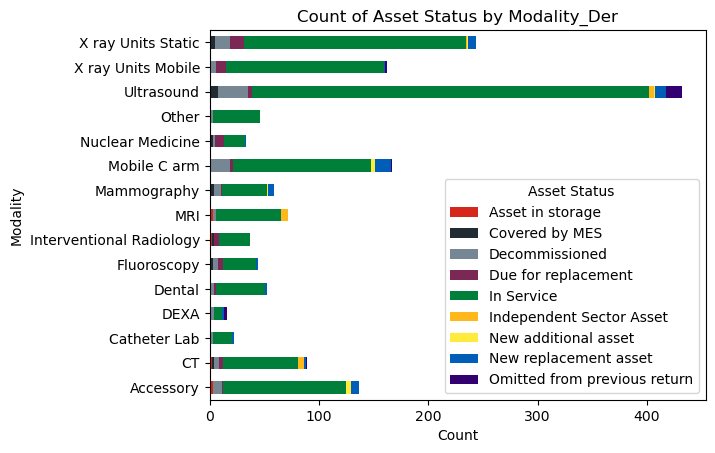

In [7]:
# Count the occurrences
count_data = df.groupby(['Modality_Der', 'Asset Status']).size().unstack().fillna(0)

# NHS colour palette dictionary
nhs_colours = {
    'Asset in storage': '#d5281b', # warm yellow
    'Covered by MES': '#212b32', # black
    'Decommissioned': '#768692', # grey 1
    'Due for replacement': '#7C2855', # red
    'In Service': '#007f3b', # blue
    'Independent Sector Asset': '#ffb81C', # yellow
    'New additional asset': '#ffeb3b', # green
    'New replacement asset': '#005eb8', # yellow
    'Omitted from previous return': '#330072' # purple
}

# Plotting
count_data.plot(kind='barh', stacked=True, color=[nhs_colours[col] for col in count_data.columns])
plt.title('Count of Asset Status by Modality_Der')
plt.xlabel('Count')
plt.ylabel('Modality')
plt.legend(title='Asset Status')
plt.show()

In [31]:
count_data

Asset Status,Asset in storage,Covered by MES,Decommissioned,Due for replacement,In Service,Independent Sector Asset,New additional asset,New replacement asset,Omitted from previous return
Modality_Der,,,,,,,,,
Accessory,3.0,0.0,8.0,1.0,113.0,0.0,4.0,8.0,0.0
CT,2.0,2.0,5.0,3.0,69.0,5.0,0.0,2.0,1.0
Catheter Lab,0.0,1.0,2.0,0.0,17.0,0.0,0.0,2.0,0.0
DEXA,1.0,0.0,3.0,0.0,7.0,0.0,0.0,2.0,3.0
Dental,0.0,0.0,4.0,2.0,45.0,0.0,0.0,1.0,0.0
Fluoroscopy,1.0,2.0,5.0,4.0,30.0,0.0,0.0,2.0,0.0
Interventional Radiology,2.0,2.0,0.0,5.0,28.0,0.0,0.0,0.0,0.0
MRI,3.0,0.0,3.0,0.0,59.0,7.0,0.0,0.0,0.0
Mammography,0.0,4.0,6.0,1.0,41.0,0.0,1.0,6.0,0.0


In [8]:
# trial with dash app...

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a list of tabs for each Modality_Der
tabs = []
modalities = sorted(df['Modality_Der'].unique())
for modality in modalities:
    df_modality = df[df['Modality_Der'] == modality]
    df_count = df_modality.groupby(['OrganisationName', 'type']).size().reset_index(name='count')
    
    # Calculate the percentage of "CDC"
    df_total = df_count.groupby('OrganisationName')['count'].sum().reset_index(name='total_count')
    df_cdc = df_count[df_count['type'] == 'CDC'].merge(df_total, on='OrganisationName')
    df_cdc['percentage'] = (df_cdc['count'] / df_cdc['total_count']) * 100
    
    # Create subplots with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add bar chart for counts
    for t in df_count['type'].unique():
        df_type = df_count[df_count['type'] == t]
        fig.add_trace(
            go.Bar(x=df_type['OrganisationName'], y=df_type['count'], name=t),
            secondary_y=False,
        )
    
    # Add line chart for percentage of "CDC"
    fig.add_trace(
        go.Scatter(x=df_cdc['OrganisationName'], y=df_cdc['percentage'], name='CDC %', mode='markers', line=dict(color='black')),
        secondary_y=True,
    )
    
    # Update layout
    fig.update_layout(
        title_text=f'Count of Assets by location type for {modality}',
        barmode='group',
        yaxis_title='Count',
        yaxis2_title='Percentage of CDC',
        legend_title='Type'
    )
    
    tabs.append(dcc.Tab(label=modality, children=[
        dcc.Graph(figure=fig)
    ]))

# Define the layout of the app
app.layout = html.Div([
    dcc.Tabs(tabs)
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
# # Define the color palette with CDC as blue and non-CDC as orange
# colors = {'non-CDC': '#1f77b4', 'CDC': '#ff7f0e'}

# # Assuming 'Modality_Der' is a column in your DataFrame
# modalities = df['Modality_Der'].unique()

# for modality in modalities:
#     # Filter the DataFrame for the current modality
#     df_modality = df[df['Modality_Der'] == modality]
    
#     # Group by 'OrganisationName' and 'type', then count
#     count_cdc = df_modality.groupby(['OrganisationName', 'type']).size().unstack().fillna(0)
    
#     # # Ensure the columns are in the correct order
#     # count_cdc = count_cdc[['CDC', 'non-CDC']]
    
#     # Plotting
#     count_cdc.plot(kind='bar', stacked=True, color=colors)
#     plt.title(f'Count of Assets by location type for {modality}')
#     plt.xlabel('Org Name')
#     plt.ylabel('Count')
#     plt.legend(title='Location Type')
#     plt.show()

Scatterplot count of modality vs avg age of asset, by provider

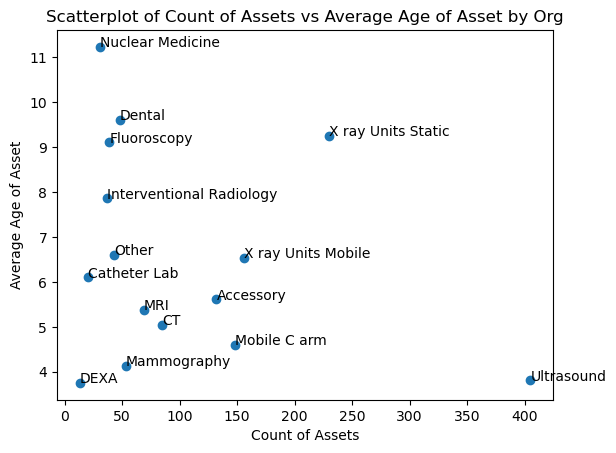

In [9]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Group by OrganisationName to get the count and average age_of_asset
grouped_df = df.groupby('Modality_Der').agg(
    count_modality=('Modality_Der', 'count'),
    avg_age_of_asset=('Age', 'mean')
).reset_index()


# Create a scatter plot
plt.scatter(grouped_df['count_modality'], grouped_df['avg_age_of_asset'])

# Add labels and title
plt.xlabel('Count of Assets')
plt.ylabel('Average Age of Asset')
plt.title('Scatterplot of Count of Assets vs Average Age of Asset by Org')

# Label dots with OrganisationName
for i, row in grouped_df.iterrows():
    plt.text(row['count_modality'], row['avg_age_of_asset'], row['Modality_Der'])

# Show the plot
plt.show()

Asset type by age

Replacement schedule and cost dictionaries

In [10]:
replacement_schedule = {
'Accessory': 5,
'CT': 8,
'Catheter Lab': 8,
'DEXA': 10,
'Dental': 10,
'Fluoroscopy': 8,
'Interventional Radiology': 8,
'MRI': 8,
'Mammography': 5,
'Mobile C arm': 8,
'Nuclear Medicine': 8,
'Other': 0,
'Ultrasound': 5,
'X ray Units Mobile': 8,
'X ray Units Static': 8,
}

replacement_cost = {
'Accessory': 22500,
'CT': 935000,
'Catheter Lab': 900000,
'DEXA': 88000,
'Dental': 33000,
'Fluoroscopy': 660000,
'Interventional Radiology': 935000,
'MRI': 1210000,
'Mammography': 330000,
'Mobile C arm': 90000,
'Nuclear Medicine': 880000,
'Other': 0,
'Ultrasound': 90000,
'X ray Units Mobile': 85000,
'X ray Units Static': 120000,
}

Stacked bar chart by provider

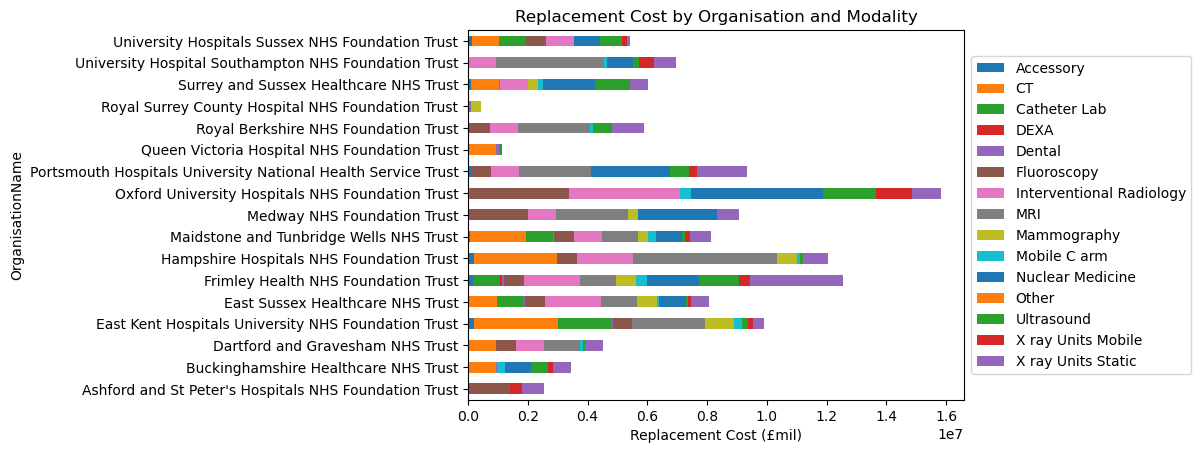

In [11]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Add replacement_cost to the DataFrame
df['replacement_cost'] = df.apply(lambda row: replacement_cost[(row['Modality_Der'])], axis=1)
df['replacement_schedule'] = df.apply(lambda row: replacement_schedule[(row['Modality_Der'])], axis=1)

# Only where Age > replacement_schedule
df = df[df['Age'] > df['replacement_schedule']]

# Pivot the DataFrame to get the data in the format required for a stacked bar chart
pivot_df = df.pivot_table(index='OrganisationName', columns='Modality_Der', values='replacement_cost', aggfunc='sum').fillna(0)

# Create a stacked bar chart
pivot_df.plot(kind='barh', stacked=True)

# Add labels and title
plt.xlabel('Replacement Cost (£mil)')
plt.ylabel('OrganisationName')
plt.title('Replacement Cost by Organisation and Modality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [51]:
pivot_df

Modality_Der,Accessory,CT,Catheter Lab,DEXA,Dental,Fluoroscopy,Interventional Radiology,MRI,Mammography,Mobile C arm,Nuclear Medicine,Other,Ultrasound,X ray Units Mobile,X ray Units Static
OrganisationName,,,,,,,,,,,,,,,
Ashford and St Peter's Hospitals NHS Foundation Trust,67500.0,0.0,0.0,0.0,0.0,1320000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,425000.0,720000.0
Buckinghamshire Healthcare NHS Trust,0.0,935000.0,0.0,0.0,33000.0,0.0,0.0,0.0,0.0,270000.0,880000.0,0.0,540000.0,170000.0,600000.0
Dartford and Gravesham NHS Trust,0.0,935000.0,0.0,0.0,0.0,660000.0,935000.0,1210000.0,0.0,90000.0,0.0,0.0,90000.0,0.0,600000.0
East Kent Hospitals University NHS Foundation Trust,202500.0,2805000.0,1800000.0,0.0,33000.0,660000.0,0.0,2420000.0,990000.0,270000.0,0.0,0.0,180000.0,170000.0,360000.0
East Sussex Healthcare NHS Trust,45000.0,935000.0,900000.0,0.0,33000.0,660000.0,1870000.0,1210000.0,660000.0,90000.0,880000.0,0.0,90000.0,85000.0,600000.0
Frimley Health NHS Foundation Trust,157500.0,0.0,900000.0,88000.0,66000.0,660000.0,1870000.0,1210000.0,660000.0,360000.0,1760000.0,0.0,1350000.0,340000.0,3120000.0
Hampshire Hospitals NHS Foundation Trust,180000.0,2805000.0,0.0,0.0,0.0,660000.0,1870000.0,4840000.0,660000.0,90000.0,0.0,0.0,90000.0,0.0,840000.0
Maidstone and Tunbridge Wells NHS Trust,67500.0,1870000.0,900000.0,0.0,33000.0,660000.0,935000.0,1210000.0,330000.0,270000.0,880000.0,0.0,90000.0,170000.0,720000.0
Medway NHS Foundation Trust,0.0,0.0,0.0,0.0,33000.0,1980000.0,935000.0,2420000.0,330000.0,0.0,2640000.0,0.0,0.0,0.0,720000.0


Boxplot to show age of asset by modality

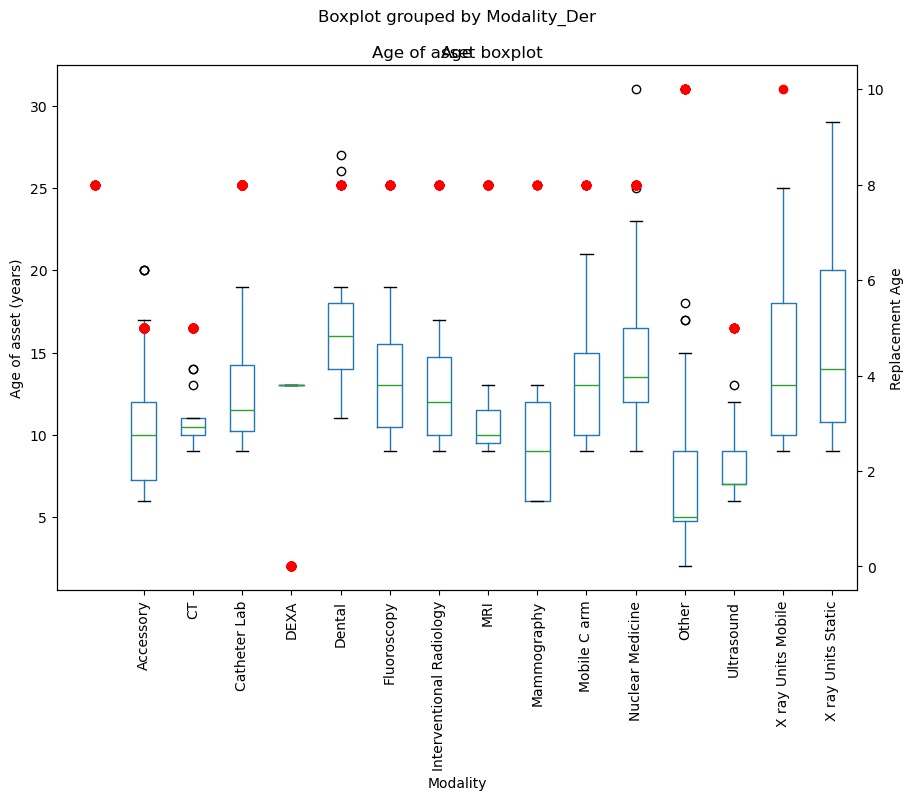

In [31]:


fig, ax1 = plt.subplots(figsize=(10, 7))

# create plot on primary y-axis for boxplot
df.boxplot(by='Modality_Der', column=['Age'], ax=ax1)

# remove gridlines
ax1.grid(False)

# rotate x labels
plt.xticks(rotation=90)

# create secondary y axis for age of replacement
ax2 = ax1.twinx()
ax2.plot(df['Modality_Der'], df['replacement_schedule'], color='r', marker='o', linestyle='')
ax2.set_ylabel('Replacement Age')

# add axis headers and title
plt.title("Age of asset boxplot")
ax1.set_xlabel("Modality")
ax1.set_ylabel("Age of asset (years)")

# show plot
plt.show()
